In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


device = 'cuda:7'

In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency
from matplotlib import pylab as P

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import random
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(42)

In [5]:
# from ig_pkg.datasets import get_datasets
# from tqdm import tqdm
import numpy as np
idx = 10
a = True
ran = np.random.randint(50000)
if idx == ran:
    while idx == ran:
        ran = np.random.randint(50000)
        print(1)
    print(0)


0


In [3]:
import numpy as np
a = np.load('/home/dhlee/results/cifar10/image_linear_zero_attribution.npy')
a.shape

(10000, 32, 32)

In [6]:
import torchvision
import torchvision.transforms as T

CIFAR10_STATS = {
'mean' : [0.4914, 0.4822, 0.4465],
'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])


valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked', train=False, transform=transform)

classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu')
model = classifier.eval().to(device)



/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


gradient descent in image domain

In [ ]:
def get_classifier_latent_direction(autoencoder, classifier, z, y):
    
    # clean the gradients 
    autoencoder.zero_grad()
    classifier.zero_grad()        
    
    z = torch.autograd.Variable(z, requires_grad=True).to(z.dtype)
    x_hat = autoencoder.decode(z)
    output = classifier(x_hat)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(z.size(0), output.size()[-1]).zero_().to(z.device).type(z.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)
    return z.grad.detach()


def integrated_gradient(model, x, y, baseline, interpolation, device='cuda:0', **kwrags):
#     x = x.to(device)
#     baseline = baseline.to(device)
#     interpolation = interpolation.to(device)
    model.zero_grad()
    
    X = Variable(interpolation, requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    gradient = (gradient[:-1] + gradient[1:]) / 2.0
    output = (x - baseline) * gradient.mean(axis=0)
    output = output.mean(dim=0) # RGB mean
    output = output.abs()
    return output

In [38]:
temp = valid_dataset[1][0]
lab = valid_dataset[1][1]
print(valid_dataset[1][1])

temp = Variable(temp, requires_grad=True).to(device)
temp = temp.unsqueeze(0)
temp.retain_grad()
model.zero_grad()

output = model(temp)
score = torch.softmax(output, dim=-1)
class_score = torch.FloatTensor(temp.size(0), output.size()[-1]).zero_().to(device).type(temp.dtype)
class_score[:,lab] = score[:,lab]
output.backward(gradient=class_score)

gradient = temp.grad  #Approximate the integral using the trapezoidal rule


8


In [54]:
def get_gradient(model, x, y, device):
    temp = Variable(x, requires_grad=True).to(device)
    temp = temp.unsqueeze(0)
    temp.retain_grad()
    model.zero_grad()

    output = model(temp)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(temp.size(0), output.size()[-1]).zero_().to(device).type(temp.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = temp.grad
    return gradient

In [ ]:
'/home/dhlee/results/cifar10/image_linear_expected_attribution.npy'

In [ ]:
def image_gradient_interpolation(model, x, y, M, device):
    model = model.to(device)
    x = x.to(device)
    
    interp = []
    interp.append(x)
    
    for i in range(M):    
        grad = get_gradient(model, x, y, device)
        x = x - grad.squeeze(0)
        # print(img_hat.size())
        score = sc
        img = img_hat
        if j > 10: break

In [66]:
for i in range(100):
    img = valid_dataset[i][0].to(device)
    lab = valid_dataset[i][1]
    j = 0
    score1 = 100
    while score1 > 0.01:
        # print(j)
        j += 1
        grad, sc = get_gradient(model, img, lab, device)
        img_hat = img - grad.squeeze(0) * 5
        # print(img_hat.size())
        score = sc
        img = img_hat
        if j > 10: break
    print(j)
        
    
    

2
3
3
3
4
3
2
3
4
4
2
5
3
3
6
2
2
10
11
3


tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9995], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9995], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9995], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9994], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9994], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9994], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9993], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9992], device='cuda:7', grad_fn=<SelectBackward0>)
tensor([0.9990], device='cuda:7', grad_fn=<SelectBackward0>)


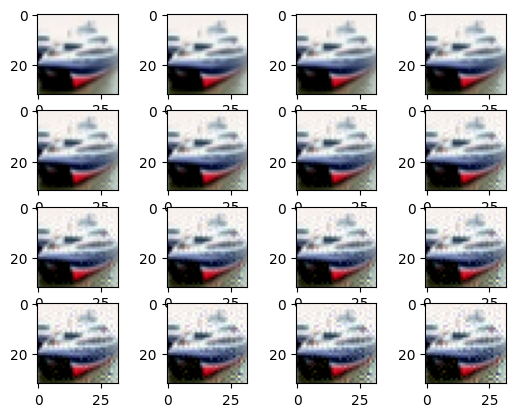

In [47]:

temp = valid_dataset[1][0].to(device)

fig, axes = plt.subplots(4, 4)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
for i in range(16):
    t = temp.squeeze(0) + i * gradient.squeeze(0) * 1
    t = t.detach().clone()
    t = t.to(device)
    output = model(t.unsqueeze(0))
    score = torch.softmax(output, dim=-1)
    print(score[:, 8])
    ax = next(axes_flat)
    ax.imshow(convert_to_img(t))

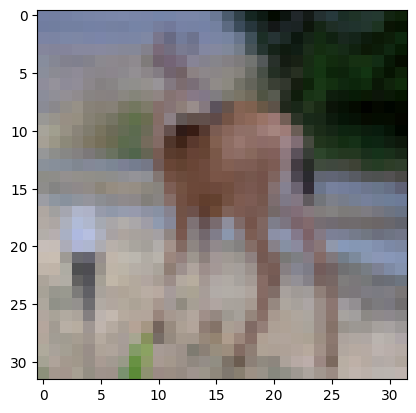

In [27]:
from ig_pkg.misc import convert_to_img

plt.imshow(convert_to_img(valid_dataset[100][0]))

/tmp/ipykernel_8682/2565103013.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d = (c*255).clip(0,255).astype(np.int)


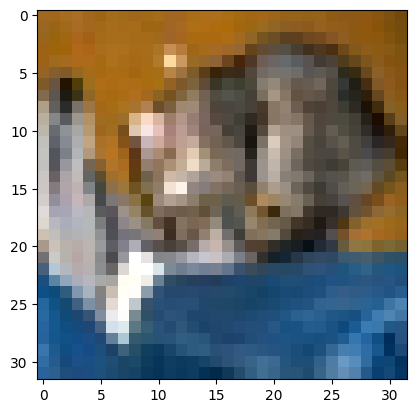

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# b = np.load('/home/dhlee/results/cifar10/image_linear_zero_interpolation.npy')
# b[0].shape
temp = np.transpose(b[0][-1], (1, 2, 0))

# def denormalize(tensor, means, stds):
#     denormalized = tensor.clone()
#     for channel, mean, std in zip(denormalized, means, stds):
#         channel.mul_(std).add_(mean)
#     return denormalized

c = temp * IMAGENET_STD + IMAGENET_MEAN
d = (c*255).clip(0,255).astype(np.int)
plt.imshow(d)

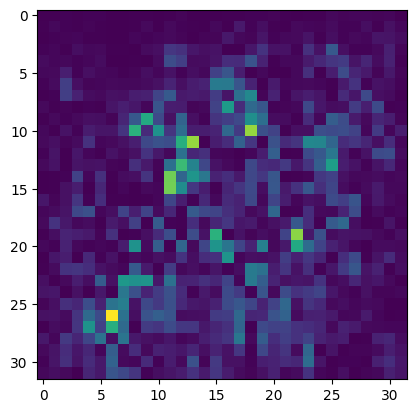

In [6]:
import matplotlib.pyplot as plt
plt.imshow(a[0])

In [3]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
eval_mode = model.eval()

In [4]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# eagle_idx = os.listdir(eagle_dir)[1]
# eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


generate baseline 

In [9]:
def make_interpolation(x, M, baseline):
    lst = [] 
    for i in range(M+1):
        alpha = float(i/M)  
        interpolated =x * (alpha) + baseline * (1-alpha)
        lst.append(interpolated.clone())
    return torch.stack(lst)

In [24]:
def integrated_gradient(model, x, y, baseline, interpolation, device='cuda:0', **kwrags):
    x = x.to(device)
    baseline = baseline.to(device)
    model.zero_grad()
    
#     X = make_interpolation(x, M, baseline)
    X = Variable(interpolation, requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    gradient = (gradient[:-1] + gradient[1:]) / 2.0
    output = (x - baseline) * gradient.mean(axis=0)
    output = output.mean(dim=0) # RGB mean
    output = output.abs()
    return output


In [25]:
# ferrot_tensor.size()
# baseline = torch.zeros_like(ferrot_tensor)
# baseline.size()

# X = make_interpolation(ferrot_tensor, 25, baseline)
# X.size()

temp = integrated_gradient(eval_mode.to("cuda:0"), ferrot_tensor, 359, baseline, X, device='cuda:0', M=25)


In [53]:
X.device

device(type='cpu')

StopIteration: 

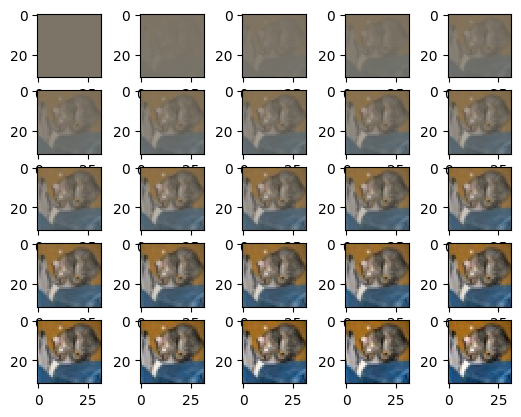

In [51]:
# temp.detach().cpu()
# a = 
result = torch.from_numpy(np.load('/root/results/cifar10/interpolation/image_linear_zero_interpolation.npy'))
t = result[0]
t.shape

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(26):
    ax = next(axes_flat)
#     b = torch.numpy_to_tensor(t[i])
#     b.size()
    ax.imshow(convert_to_img(t[i]))
#     ax.imshow(np.transpose(t[i], (1, 2, 0)))



In [45]:
t[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [30]:
# model = torch.load('/root/data/cifar10/cifar10/results/densenet/script_model.pt', map_location='cpu')
model.weight

AttributeError: 'RecursiveScriptModule' object has no attribute 'weight'

In [33]:
a, b = valid_datasets[0]
b.type()

AttributeError: 'int' object has no attribute 'type'

In [ ]:
def get_classifier_latent_direction(autoencoder, classifier, z, y):
    
    # clean the gradients 
    autoencoder.zero_grad()
    classifier.zero_grad()        
    
    z = torch.autograd.Variable(z, requires_grad=True).to(z.dtype)
    x_hat = autoencoder.decode(z)
    output = classifier(x_hat)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(z.size(0), output.size()[-1]).zero_().to(z.device).type(z.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)
    return z.grad.detach()